# Plot numerically computed matern correlation lengths compared to theory

In [68]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

import cmocean
import warnings

In [69]:
fig_dir = '../figures'
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [70]:
plt.style.use('./correlation.mplstyle')

In [71]:
horizontal_factor = 1
n_ranges = [5, 10, 15, 20]
log10tol = -15
n_samples = 1000
corrs = []
for n_range in n_ranges:
    fname = f"/scratch2/tsmith/generic-matern-covariance/sampling/llc90/zstores/matern-corr/log10tol{log10tol:03d}.{n_range:02d}dx.{horizontal_factor:02}xi.{n_samples}samples"
    corrs.append(xr.open_zarr(fname))
    
cds = xr.concat(corrs, dim='n_range')

In [72]:
cds.nbytes / 1e9

2.232829528

In [73]:
cds.load();

## Comparison to theory

In [74]:
kk = 25
ix = 90
iy = 165

In [75]:
def plot_correlation(xds, dim, dsel, ax):
    
    adims = tuple(d for d in ('ix','iy','k') if d != dim)
    
    theory_label = r'$r\,(\hat{\rho},||\hat{x}_1-\hat{x}_2||)$' if xds.n_range == 5 and dim == 'k' else None
    exp_label=r'$\hat{\rho}$ = %d' % n_range if dim == 'k' else None
    
    # for simplicity, just showing positive, but it's the same either way...
    condition = xds['shifty'] >= 0
    if dim == 'k':
        condition = condition & (xds.rho_hat<25)
        
    x = xds['rho_hat'].where(condition)
    theory = xds[f'ideal_corr'].where(condition)
    yavg = xds[f"corr_{dim}"].where(condition).mean(adims)
    ystd = xds[f"corr_{dim}"].where(condition).std(adims)
    spread = xds[f"corr_{dim}"].where(condition).quantile([.1, .9], dim=adims)
    
    ax.plot(x, theory, label=theory_label, color='black')
    ax.fill_between(x,
                    spread.isel(quantile=0),
                    spread.isel(quantile=-1),
                    #yavg-ystd,
                    #yavg+ystd,
                    alpha=.3,
                    label=exp_label)

    lbl = dim[-1]
    lbl = 'z' if lbl == 'k' else lbl
    ax.axhline(y=0.14, color='gray', alpha=.2)
    ax.set(xlabel=r'$\delta\hat{%s}$' % lbl,ylabel='',title='')

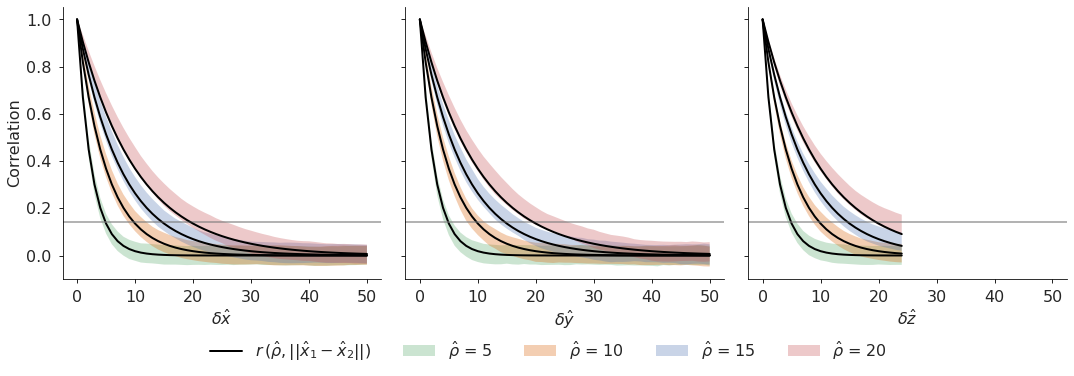

In [76]:
ncols = 3
nrows = 1

fig,axs = plt.subplots(nrows,ncols,figsize=(18,5*nrows),
                       sharey=True,
                       sharex=True)

for dim, dsel, ax in zip(['ix','iy','k'], [ix,iy,kk], axs):
    for n_range in cds.n_range.values:
        xds = cds.sel({dim:dsel, "n_range":n_range}).squeeze()
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            plot_correlation(xds, dim, dsel, ax)
        
        
axs[0].set_ylabel('Correlation')
#[ax.set(xlim=[None, 40]) for ax in axs]

fig.subplots_adjust(wspace=.075)
fig.legend(ncol=5,
           loc='center',
           bbox_to_anchor=(.5,-0.075),
           frameon=False)
#axs[-1].legend(loc='center left', bbox_to_anchor=(1., .5))
fig.savefig(f'{fig_dir}/matern_llc90_correlation-k{kk}-iy{iy}-ix{ix}-{n_samples}samples-4curves.pdf', bbox_inches='tight')